In [1]:
from enrichment_functions import * 

import matplotlib.pyplot as plt
from draw_wordcloud import draw_word_cloud

from Bio import SeqIO

import json
import gzip

### Parse GO files

In [2]:
# file containing gene ontology
GO_FILE_PATH = "../../data/go.json.gz"

# file containin HUMAN GO annotations
MAP_FILE_PATH = "../../data/goa_human.gaf.gz"

In [3]:
# read ontology file
with gzip.open(GO_FILE_PATH) as f:
    ontology = json.load(f)

# parse ontology
labels, ancestors, min_depth = parse_gene_ontology(ontology)

In [4]:
# Map proteins ID to GO term
protein_to_go = map_protein_to_go(MAP_FILE_PATH)

# Original Dataset

In [5]:
# read the original dataset (hits retrieved by our model)
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()

In [6]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [7]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(background, ancestors, protein_to_go)

In [8]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [9]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0035685,102.965166,0.000548,4,helper T cell diapedesis
0033277,102.965166,0.000548,4,abortive mitotic cell cycle
0001545,102.958708,0.019147,2,primary ovarian follicle growth
1900234,102.958708,0.019147,6,regulation of Kit signaling pathway
0008269,102.958708,0.019147,5,JAK pathway signal transduction adaptor activity


In [11]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.9297568506368197e-05


In [12]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= adjusted_threshold)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
0005942,44.155188,2.723075e-15,3,phosphatidylinositol 3-kinase complex
0051219,38.067051,1.430328e-35,3,phosphoprotein binding
0031295,23.326910,1.571818e-12,3,T cell costimulation
0031294,22.894917,1.904113e-12,2,lymphocyte costimulation
0005158,22.387696,6.727561e-06,3,insulin receptor binding


Visualize the first term here

https://www.ebi.ac.uk/QuickGO/GTerm?id=GO:0005942

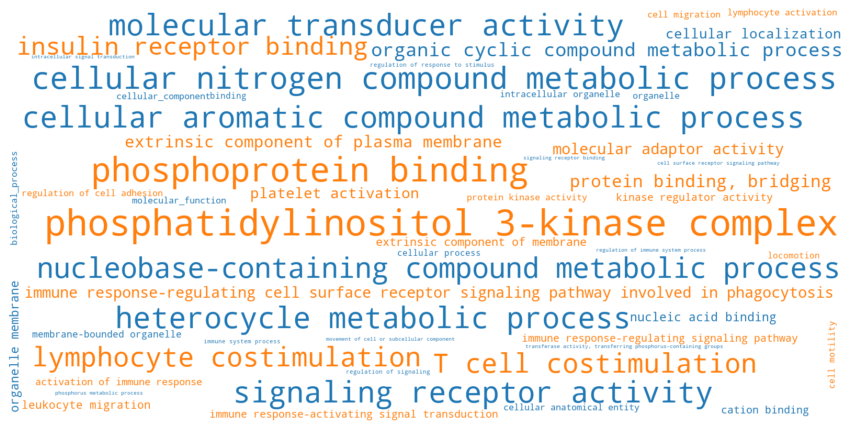

In [14]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    scale = 2,
    under_represented=True
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()